In [21]:
import pandas as pd

# ============================
# 1. CSV の読み込み
# ============================

df = pd.read_csv("/Users/kosakakenta/Downloads/work_dataset/games.csv", encoding="cp932")


if "home_team_score" in df.columns and "away_team_score" in df.columns:
    # ============================
    # 2. 勝敗判定用の列を作る
    # ============================
    df["winner"] = None
    df["loser"] = None

    # 引き分け判定
    df["is_draw"] = df["home_team_score"] == df["away_team_score"]

    # ホーム勝利
    home_win = df["home_team_score"] > df["away_team_score"]
    df.loc[home_win, "winner"] = df.loc[home_win, "home_team_id"]
    df.loc[home_win, "loser"]  = df.loc[home_win, "away_team_id"]

    # アウェイ勝利
    away_win = df["home_team_score"] < df["away_team_score"]
    df.loc[away_win, "winner"] = df.loc[away_win, "away_team_id"]
    df.loc[away_win, "loser"]  = df.loc[away_win, "home_team_id"]

    # ============================
    # 3. チームごとの勝敗数を集計
    # ============================

    # 勝利数
    wins = (
        df.dropna(subset=["winner"])
          .groupby(["game_year", "winner"])
          .size()
          .reset_index(name="wins")
          .rename(columns={"winner": "team_id"})
    )

    # 敗北数
    losses = (
        df.dropna(subset=["loser"])
          .groupby(["game_year", "loser"])
          .size()
          .reset_index(name="losses")
          .rename(columns={"loser": "team_id"})
    )

    # 引き分け数（ホーム側）
    draws_home = (
        df[df["is_draw"]]
          .groupby(["game_year", "home_team_id"])
          .size()
          .reset_index(name="draws")
          .rename(columns={"home_team_id": "team_id"})
    )

    # 引き分け数（アウェイ側）
    draws_away = (
        df[df["is_draw"]]
          .groupby(["game_year", "away_team_id"])
          .size()
          .reset_index(name="draws")
          .rename(columns={"away_team_id": "team_id"})
    )

    # 引き分けを合算
    draws = pd.concat([draws_home, draws_away], ignore_index=True)
    draws = draws.groupby(["game_year", "team_id"])["draws"].sum().reset_index()

    # ============================
    # 4. 勝敗表を結合して勝率計算
    # ============================

    standings = (
        wins.merge(losses, on=["game_year", "team_id"], how="outer")
            .merge(draws, on=["game_year", "team_id"], how="outer")
    )

    # NaN → 0 に変換
    standings = standings.fillna(0)

    # 総試合数
    standings["total_games"] = standings["wins"] + standings["losses"] + standings["draws"]

    # 勝率（引き分けを勝ち0.5扱いにする場合は式を変更する）
    denom = standings["wins"] + standings["losses"]
    standings["win_pct"] = standings["wins"] / denom.replace({0: pd.NA})
    standings["win_pct"] = standings["win_pct"].fillna(0)

    # ソート（勝率順）
    standings = standings.sort_values(["game_year", "win_pct"], ascending=[True, False])

    # ============================
    # team_id → team_name の対応表を作る
    # ============================

    team_master_home = df[["home_team_id", "home_team_name"]] \
        .rename(columns={"home_team_id": "team_id", "home_team_name": "team_name"})

    team_master_away = df[["away_team_id", "away_team_name"]] \
        .rename(columns={"away_team_id": "team_id", "away_team_name": "team_name"})

    team_master = pd.concat([team_master_home, team_master_away]).drop_duplicates()

    standings = standings.merge(team_master, on="team_id", how="left")

    standings = standings[[
        "game_year", "team_id", "team_name",
        "wins", "losses", "draws", "total_games", "win_pct"
    ]]

else:
    standings = df.copy()

    unnamed_cols = [c for c in standings.columns if c.startswith("Unnamed")]
    if unnamed_cols:
        standings = standings.drop(columns=unnamed_cols, errors="ignore")

    for col in ("game_year", "team_id", "team_name"):
        if col not in standings.columns:
            standings[col] = None

    for col in ("wins", "losses", "draws", "total_games"):
        if col not in standings.columns:
            standings[col] = 0

    if "win_pct" not in standings.columns:
        if ("wins" in standings.columns) and ("losses" in standings.columns):
            denom = standings["wins"] + standings["losses"]
            standings["win_pct"] = standings["wins"] / denom.replace({0: pd.NA})
            standings["win_pct"] = standings["win_pct"].fillna(0)
        else:
            standings["win_pct"] = 0

    standings = standings[[
        "game_year", "team_id", "team_name",
        "wins", "losses", "draws", "total_games", "win_pct"
    ]]

# ============================
# 5. 結果表示
# ============================
print(standings)

# csvに保存
standings.to_csv("/Users/kosakakenta/Downloads/work_dataset/win_pct.csv", index=False, encoding="utf-8-sig")

    game_year  team_id team_name  wins  losses  draws  total_games   win_pct
0        2021        2      ヤクルト    79      54     19          152  0.593985
1        2021        5        阪神    77      58     10          145  0.570370
2        2021       11     オリックス    74      59     19          152  0.556391
3        2021        9       ロッテ    68      59     21          148  0.535433
4        2021      376        楽天    66      63     16          145  0.511628
5        2021        1        巨人    63      64     21          148  0.496063
6        2021       12    ソフトバンク    60      62     21          143  0.491803
7        2021        6        広島    63      68     12          143  0.480916
8        2021        8      日本ハム    55      68     20          143  0.447154
9        2021        7        西武    55      70     18          143  0.440000
10       2021        4        中日    55      71     17          143  0.436508
11       2021        3      DeNA    54      73     16          143  0.425197

read '/Users/kosakakenta/Downloads/work_dataset/win_pct.csv' with encoding='utf-8-sig'
read '/Users/kosakakenta/Downloads/work_dataset/stats_bat.csv' with encoding='cp932'
          win_pct   team_hr
win_pct  1.000000  0.340337
team_hr  0.340337  1.000000


/Users/kosakakenta/dsprog2_gw /dsprog2_gw/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21213 (\N{CJK UNIFIED IDEOGRAPH-52DD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kosakakenta/dsprog2_gw /dsprog2_gw/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kosakakenta/dsprog2_gw /dsprog2_gw/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kosakakenta/dsprog2_gw /dsprog2_gw/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22593 (\N{CJK UNIFIED IDEOGRAPH-5841}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kosakakenta/dsprog2_g

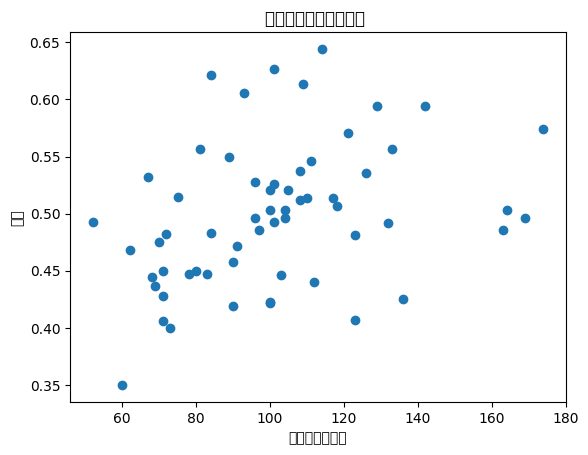

In [22]:
import matplotlib.pyplot as plt

def try_read_csv(path, encodings=("utf-8-sig", "utf-8", "cp932", "shift_jis")):
   
    last_exc = None
    for enc in encodings:
        try:
            df = pd.read_csv(path, encoding=enc)
            print(f"read {path!r} with encoding={enc!r}")
            return df
        except UnicodeDecodeError as e:
            last_exc = e
            # 次のエンコーディングを試す
            continue
        except Exception as e:
            # ファイルが存在しないなど他のエラーは即時伝える
            raise
    # 全ての試行で UnicodeDecodeError になった場合は例外を投げる
    raise last_exc if last_exc is not None else RuntimeError(f"failed to read {path!r}")

# ファイルを安全に読み込む（BOM を含む UTF-8 や cp932 のどちらでも対応）
standings = try_read_csv("/Users/kosakakenta/Downloads/work_dataset/win_pct.csv")
bat       = try_read_csv("/Users/kosakakenta/Downloads/work_dataset/stats_bat.csv")

# チーム別HR集計
team_hr = (
    bat.groupby(["season_year", "team_id"], as_index=False)["hr"]
       .sum()
       .rename(columns={"hr": "team_hr"})
)

# 勝率と結合
merged = standings.merge(
    team_hr,
    left_on=["game_year", "team_id"],
    right_on=["season_year", "team_id"],
    how="left"
)

# 相関係数
print(merged[["win_pct", "team_hr"]].corr())

# 散布図
plt.scatter(merged["team_hr"], merged["win_pct"])
plt.xlabel("チーム本塁打数")
plt.ylabel("勝率")
plt.title("本塁打数と勝率の関係 ")
plt.show()